In [ ]:
!pip install -q datasets
!pip install -q pytorch-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np

import torch
from pytorch_transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig

from datasets import load_dataset
from sklearn import metrics

from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sn

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

config = RobertaConfig.from_pretrained("roberta-base")
config.num_labels = 14

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Change commented line for training from scratch
#model = RobertaForSequenceClassification(config)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=14, output_attentions = False, output_hidden_states = False)


model = model.to(device)

100%|██████████| 501200538/501200538 [00:11<00:00, 43602395.41B/s]


In [ ]:
# Loading in dataset and creating list of pre-selected labels to be used
dataset = load_dataset("go_emotions", "simplified")
print(dataset)

# Using index of keys instead of dataset's label number
used_labels = {0: "Admiration", 2: "Anger", 3: "Annoyance", 8: "Desire", 9: "Disappointment", 10: "Disapproval", 11: "Disgust", 14: "Fear", 18: "Love", 20: "Optimism", 22: "Realisation", 24: "Remorse", 26: "Surprise", 27: "Neutral"}

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [ ]:
labels = list(used_labels.keys())

# Filtering dataset
edited_dataset = dataset.filter(lambda x: len(x["labels"]) == 1 and x["labels"][0] in labels)
print(edited_dataset.shape)

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

{'train': (25384, 3), 'validation': (3166, 3), 'test': (3246, 3)}


Text(0.5, 1.0, 'Data Split Size')

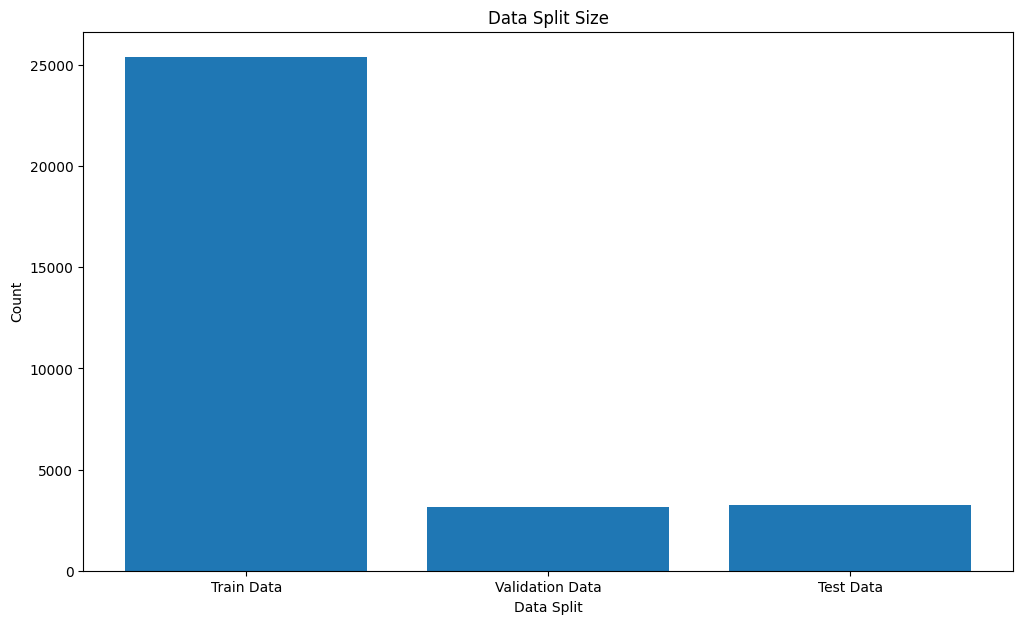

In [ ]:
# Data split size comparison
plt.figure(figsize = (12, 7))
sizes = [i[0] for i in list(edited_dataset.shape.values())]
names = [i.capitalize() + " Data" for i in edited_dataset.shape.keys()]
plt.bar(names, sizes)
plt.ylabel("Count")
plt.xlabel("Data Split")
plt.title("Data Split Size")

In [ ]:
def plotLabelCount(data_split, ignore_neutral=False):

  labels_count = Counter([i[0] for i in edited_dataset[data_split]["labels"]])
  labels_count = [labels_count[i] for i in labels]
  values = list(used_labels.values())

  if ignore_neutral:
    labels_count.pop()
    values.pop()

  plt.figure(figsize = (12, 7))
  plt.bar(values, labels_count)
  plt.tick_params(axis="x", rotation=90)
  plt.title(data_split.capitalize() + " Data")
  plt.xlabel("Label")
  plt.ylabel("Count")

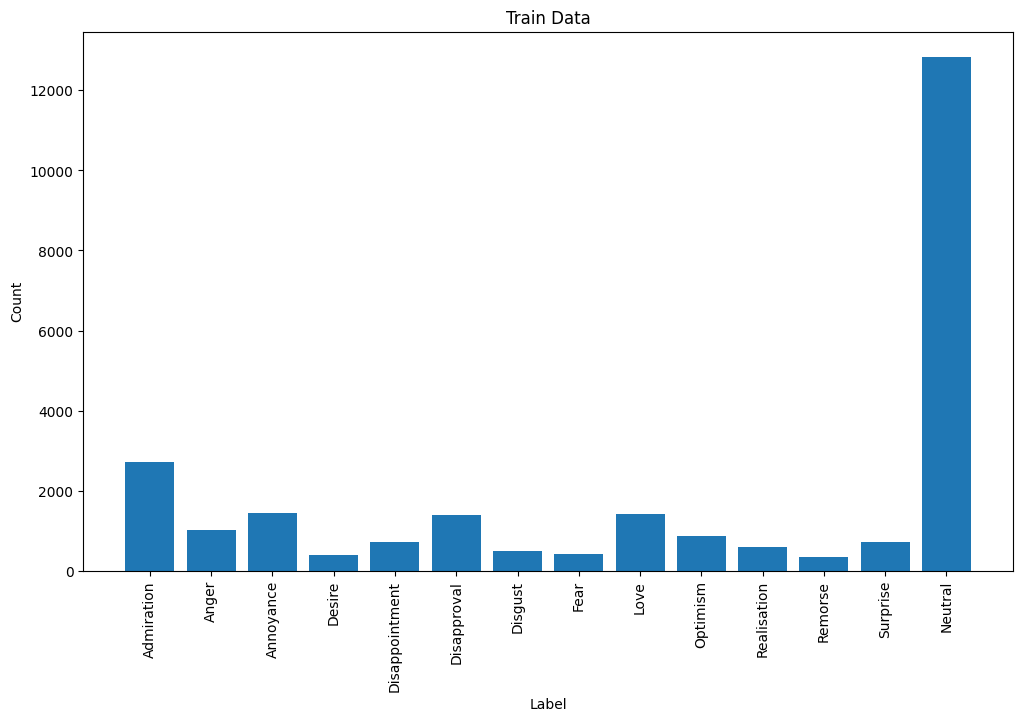

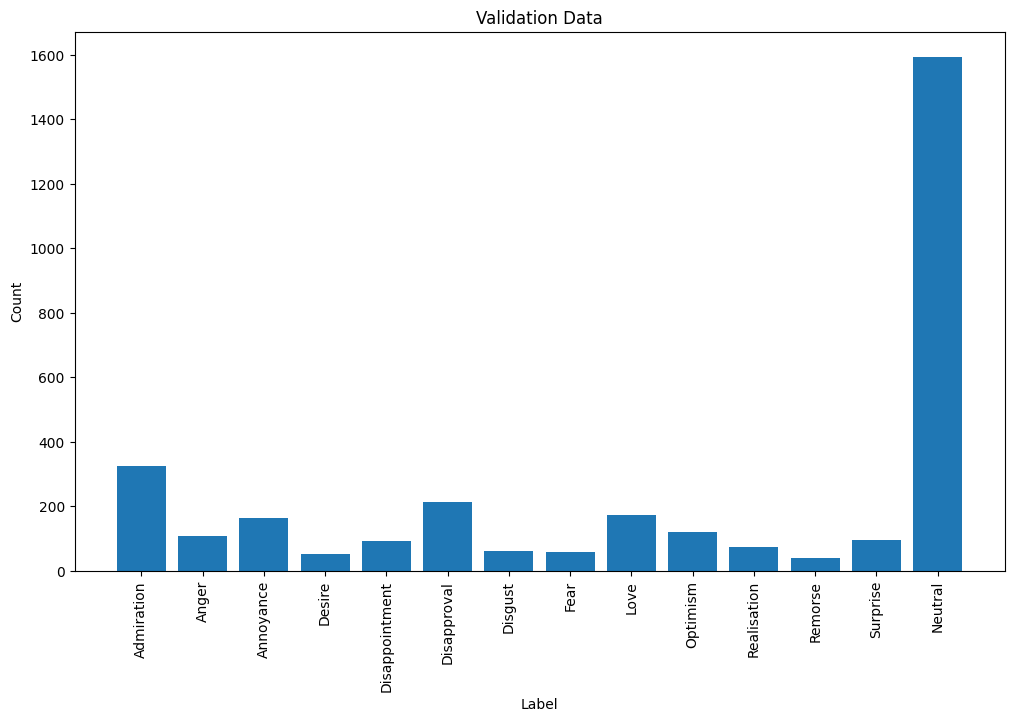

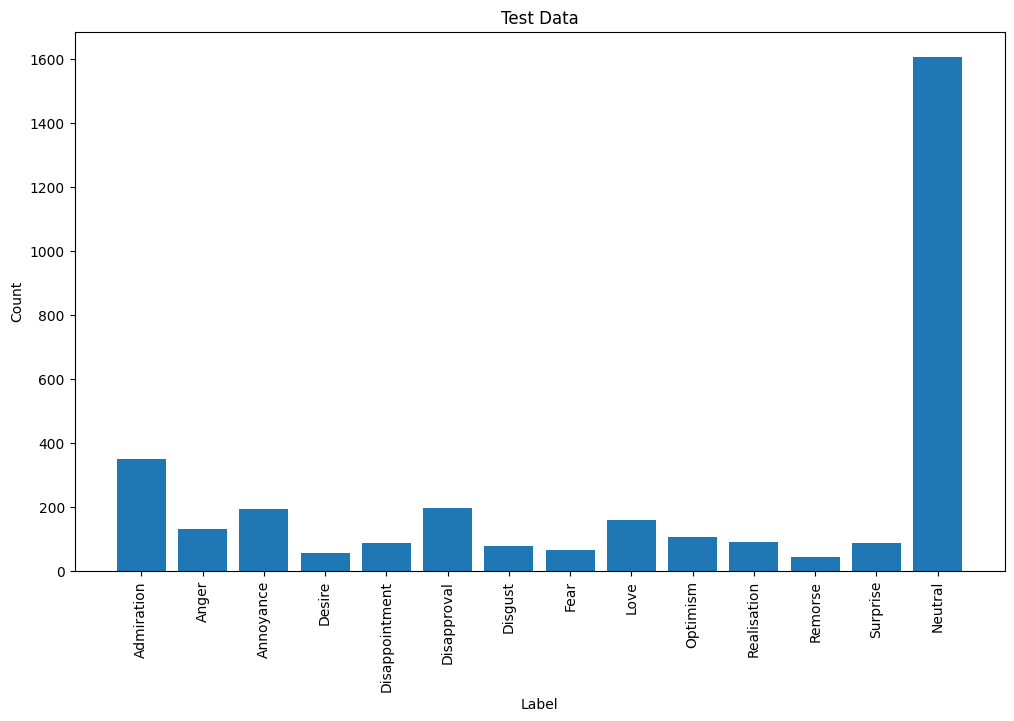

In [ ]:
# Comparison of number of pieces of data with each label
plotLabelCount("train")
plotLabelCount("validation")
plotLabelCount("test")

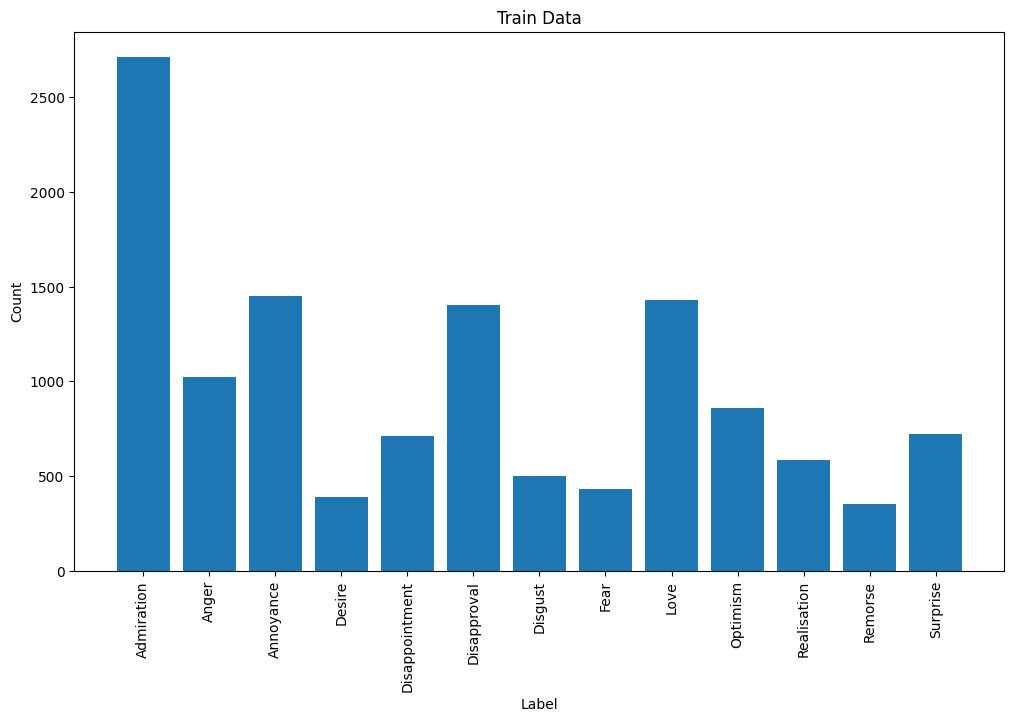

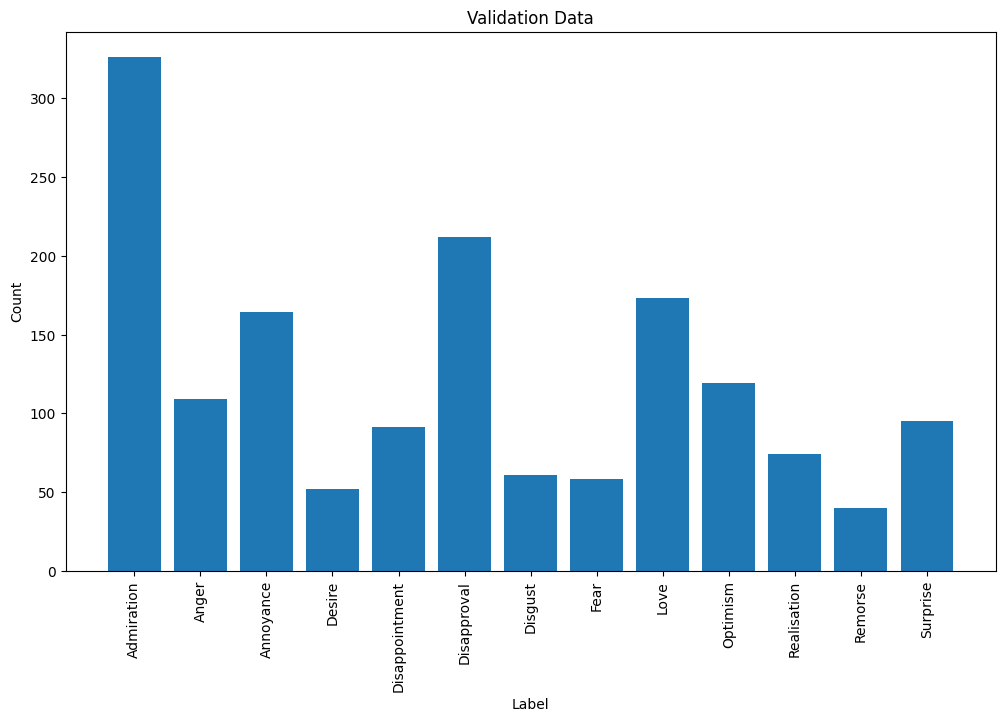

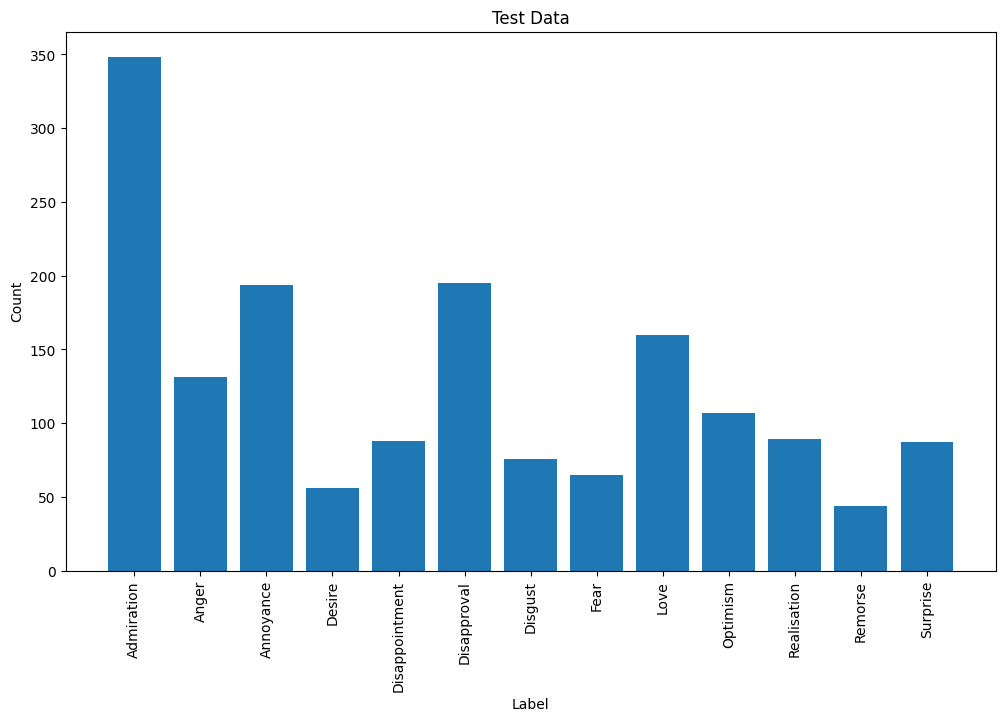

In [ ]:
# Comparison of number of pieces of data with each label ignoring neutral
plotLabelCount("train", True)
plotLabelCount("validation", True)
plotLabelCount("test", True)

In [ ]:
# Takes each sentence from the dataset and converts it into tokens whilst adding in the required special tokens
def tokenize(text, max_length = 50, cls_token = True, sep_token = True):

  tokens = tokenizer.tokenize(text)

  if len(tokens) > max_length:
        tokens = tokens[0:(max_length)]
  
  if cls_token:
      tokens.insert(0, tokenizer.cls_token)

  if sep_token:
      tokens.append(tokenizer.sep_token)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_mask = [1] * len(input_ids)

  return torch.tensor(input_ids).unsqueeze(0), input_mask

In [ ]:
# Subclass of the pytorch Dataset class, used to process data by the model
class CustomDataset(torch.utils.data.Dataset):
  
    def __init__(self, dataframe, labels):
        self.len = len(dataframe)
        self.data = dataframe
        self.labels = labels
        
    def __getitem__(self, index):
        text = self.data[index]["text"]
        tokens, _  = tokenize(text)
        label = self.data[index]["labels"][0]
        label = self.labels.index(label)

        return tokens, label
    
    def __len__(self):
        return self.len


In [ ]:
# Setting the parameters for processing the data, before doing the actual processing
parameters = {"batch_size": 32, "shuffle": True, "drop_last": True, "num_workers": 0}

train_data = CustomDataset(edited_dataset["train"], labels)
test_data = CustomDataset(edited_dataset["test"], labels)
val_data = CustomDataset(edited_dataset["validation"], labels)

train_loader = torch.utils.data.DataLoader(train_data)
val_loader = torch.utils.data.DataLoader(val_data)
test_loader = torch.utils.data.DataLoader(test_data)

# Uncomment to combine training data with validation data
#train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([train_data, val_data]))

# Uncomment for half of training data split between validation and test data
#quarter = int(len(train_data)/4)
#train_val, train_test, train = torch.utils.data.random_split(train_data, [quarter, quarter, len(train_data) - 2*quarter])
#train_loader = torch.utils.data.DataLoader(train)
#val_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([val_data, train_val]))
#test_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([test_data, train_test]))

In [ ]:
print(next(iter(train_loader))[0])
print(next(iter(train_loader))[0].squeeze(0))
print(tokenize("test")[0])

# tokenize [0], no squeeze
# May need _, predicted = torch.max(output, 1)

tensor([[[   0, 1308, 5548,  689,   16,  932,   38,  399,   75,   33,    7,
          7142, 2185,    4,    2]]])
tensor([[   0, 1308, 5548,  689,   16,  932,   38,  399,   75,   33,    7, 7142,
         2185,    4,    2]])
tensor([[   0, 1296,    2]])


In [ ]:
# Defining the loss function and optimizer as well as the learning rate for the model to use

# Uncomment loss function to use
loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.NLLLoss()


# Uncomment learning rate to use
lr = 1e-05
#lr = 1e-04
#lr = 1e-06

# Uncomment optimizer to use
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
#optimizer = torch.optim.RMSprop(params=model.parameters(), lr=lr)

In [ ]:
# Uncomment to skip cell and use other model training loop (For no validation data)
#%%script false --no-raise-error

version = 11
max_epochs = 2
model = model.train()

# Training
for epoch in range(max_epochs):
    print(f"EPOCH {epoch}")

    for iteration, (tokens, label) in enumerate(train_loader):

        optimizer.zero_grad()
        tokens = tokens.squeeze(0)

        tokens = tokens.to(device)
        label = label.to(device)

        output = model.forward(tokens)[0]
        _, predicted = torch.max(output, 1)
        
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        # Loss and Accuracy calculations
        if iteration % 6000 == 0 or iteration == 25383:

            if iteration == 25383:
              torch.save(model.state_dict(), f"drive/My Drive/NLP Model Params/model_v{version}_epoch_{epoch}.pth")

            correct = 0
            total = 0

            for tokens, label in val_loader:

                tokens = tokens.squeeze(0)
                tokens = tokens.to(device)
                label = label.to(device)

                output = model.forward(tokens)[0]
                _, predicted = torch.max(output.data, 1)

                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()

            accuracy = 100.00 * correct.numpy() / total
            print(f"Iter: {iteration}. Val Loss: {loss.item():.3f}. Val Accuracy: {accuracy:.3f}%")

EPOCH 0
Iter: 0. Val Loss: 3.065. Val Accuracy: 3.341%


KeyboardInterrupt: ignored

In [ ]:
# Comment out to use this cell's training loop, for no validation data
%%script false --no-raise-error
version = 11
max_epochs = 2
model = model.train()

#Adjusted model training for use without validation data
for epoch in range(max_epochs):
    print(f"EPOCH {epoch}")
    
    correct = 0
    total = 0
    for iteration, (tokens, label) in enumerate(train_loader):

        optimizer.zero_grad()
        tokens = tokens.squeeze(0)

        tokens = tokens.to(device)
        label = label.to(device)

        output = model.forward(tokens)[0]
        _, predicted = torch.max(output, 1)
        
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        
        total += label.size(0)
        correct += (predicted.cpu() == label.cpu()).sum()

        # Uses training data for loss and accuracy calculations
        if iteration % 6000 == 0 or iteration == 25383:

            if iteration == 25383:
              torch.save(model.state_dict(), f"drive/My Drive/NLP Model Params/model_v{version}_epoch_{epoch}.pth")


            accuracy = 100.00 * correct.numpy() / total
            print(f"Iter: {iteration}. Train Loss: {loss.item():.3f}. Train Accuracy: {accuracy:.3f}%")

            correct = 0
            total = 0

In [ ]:
# Saving the weights of the model
torch.save(model.state_dict(), f"drive/My Drive/NLP Model Params/model_v{version}_final.pth")

In [ ]:
# Loading a model from previously saved weights
model_path = f"drive/My Drive/NLP Model Params/model_v3_final.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [ ]:
import joblib

In [ ]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [ ]:
correct = 0
total = 0

true_labels = []
pred_labels = []

# Using the model to make predictions on the test data
for tokens, label in test_loader:

    tokens = tokens.squeeze(0)
    tokens = tokens.to(device)
    label = label.to(device)

    output = model.forward(tokens)[0]
    _, predicted = torch.max(output.data, 1)
    total += label.size(0)

    predicted = predicted.cpu()
    label = label.cpu()

    true_labels.extend(label)
    pred_labels.extend(predicted)

    correct += (predicted == label).sum()

accuracy = 100.00 * correct.numpy() / total
print(f"Test Accuracy: {accuracy:.3f}%")

label_names = [used_labels[i] for i in labels]

Test Accuracy: 60.813%


In [ ]:
# Generate and display classification report
classif_report = metrics.classification_report(true_labels, pred_labels, target_names=label_names)
print(classif_report)

                precision    recall  f1-score   support

    Admiration       0.77      0.50      0.61       348
         Anger       0.00      0.00      0.00       131
     Annoyance       0.00      0.00      0.00       194
        Desire       0.67      0.18      0.28        56
Disappointment       0.00      0.00      0.00        88
   Disapproval       0.00      0.00      0.00       195
       Disgust       0.14      0.07      0.09        76
          Fear       0.00      0.00      0.00        65
          Love       0.81      0.81      0.81       160
      Optimism       0.74      0.60      0.66       107
   Realisation       0.00      0.00      0.00        89
       Remorse       0.63      0.75      0.69        44
      Surprise       0.25      0.16      0.19        87
       Neutral       0.59      0.96      0.73      1606

      accuracy                           0.61      3246
     macro avg       0.33      0.29      0.29      3246
  weighted avg       0.47      0.61      0.51 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

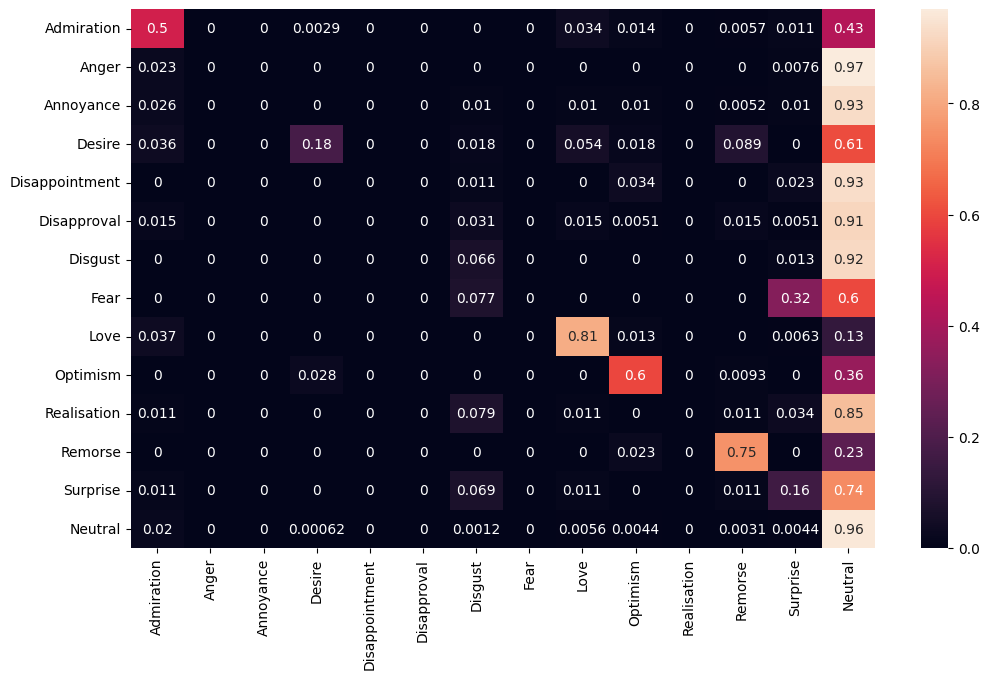

In [ ]:
# Generate and display confusion matrix
confusion = metrics.confusion_matrix(true_labels, pred_labels)
confusion_data = pd.DataFrame(confusion / np.sum(confusion, axis=1)[:, None], index = label_names, columns = label_names)

plt.figure(figsize = (12, 7))
sn.heatmap(confusion_data, annot=True)